In [1]:
import h5py
import numpy as np
import torch, monai
import torchio as tio
from typing import Sequence
from monai.data import ArrayDataset, DataLoader, PersistentDataset
from monai.transforms import Compose, RandAffine, Rand2DElastic, Rand3DElastic
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import nibabel as nib
from utils import *

import glob, os
from monai.transforms import (
    Compose,
    LoadImage,
    Rand3DElastic,
    RandSpatialCrop,
    ScaleIntensity,
    RandFlip,
    RandRotate90
)

from monai.utils import first   
from tqdm import tqdm

In [2]:
monai.utils.set_determinism(10) # Fixes the seed (for reproducibility)
monai.config.deviceconfig.print_config() # Prints PyTorch GPU information and MONAI dependencies

MONAI version: 1.1.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.13.0
gdown version: 4.7.1
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-t

## Visualize Data

In [3]:
f = h5py.File('datasets/IXI/train/data.mat','r')

print("data_x shape: ", f['data_x'].shape)
print("data_y shape: ", f['data_y'].shape)

t1 = f['data_x'][:,:,20,0] # One slice of t1 (256,256)
t2 = f['data_y'][:,:,20,0] # One slice of t2 (256, 256)

blended_align = blend_and_transpose(t1, t2) # Blend two images

print("t1 shape: ", t1.shape)
print("t2 shape: ", t2.shape)
print("blended_img shape: ", blended_align.shape)

data_x shape:  (256, 256, 2275, 3)
data_y shape:  (256, 256, 2275, 3)
t1 shape:  (256, 256)
t2 shape:  (256, 256)
blended_img shape:  (256, 256, 3)


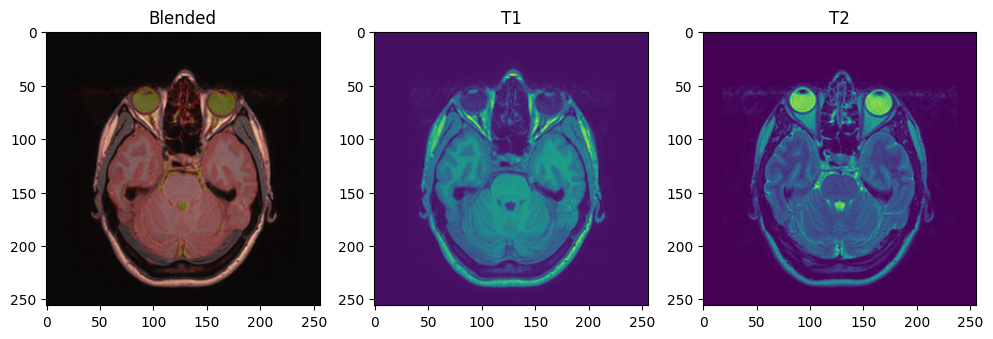

In [4]:
plot_images([blended_align, t1,t2], ['Blended', 'T1', 'T2']) # Plot the images

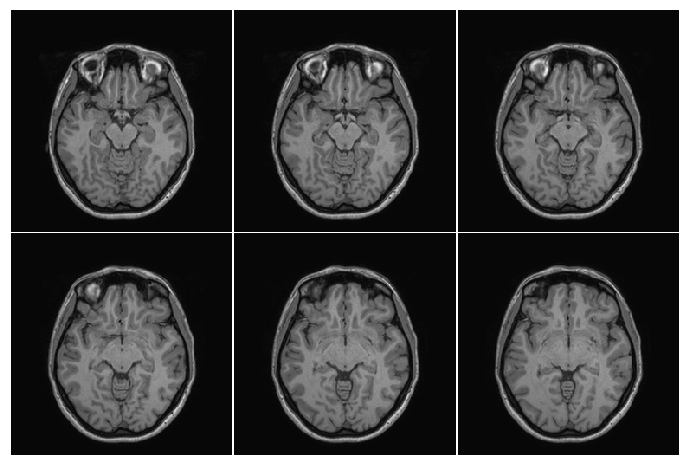

In [5]:
fig = matshow3d(f['data_x'][:,:,30:36,0], frame_dim=-1, show=True, cmap='gray', figsize=(7,7)) # Plot 3D image (multi-slice)

# Preprocessing for Training dataset

## 1. Change `data.mat` to `t1_xx.nii` and `t2_xx.nii` files

- Subject별로 있어서, misalign simulation 하기 편함 (3D translation, etc)

In [ ]:
# Load File
f = h5py.File('datasets/IXI/train/data.mat','r')

# Training
# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/train/t1"
save_slices_to_nii(sliced_array, output_prefix) # See the definition in utils.py file

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/train/t2"
save_slices_to_nii(sliced_array, output_prefix)

# Validation
f = h5py.File('datasets/IXI/val/data.mat','r')

# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/val/t1"
save_slices_to_nii(sliced_array, output_prefix) 

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/val/t2"
save_slices_to_nii(sliced_array, output_prefix)

# Testing
f = h5py.File('datasets/IXI/test/data.mat','r')

# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/test/t1"
save_slices_to_nii(sliced_array, output_prefix) 

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/test/t2"
save_slices_to_nii(sliced_array, output_prefix)


## 2. Apply misalignment for each subjects

In [10]:
transform_list = [] # After observing the transform result, save only the desired param to the list

Patient number:  1


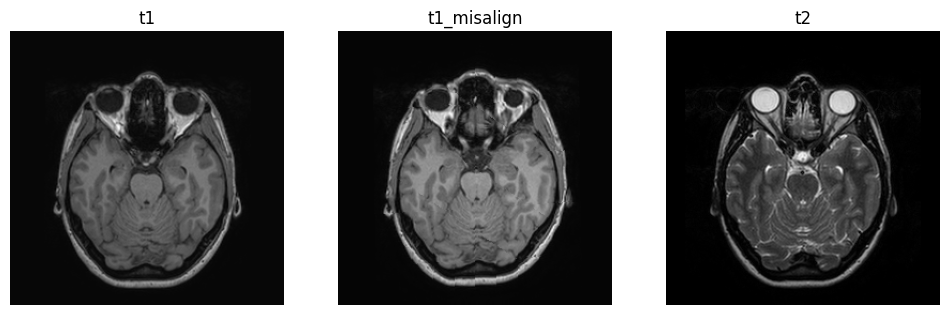

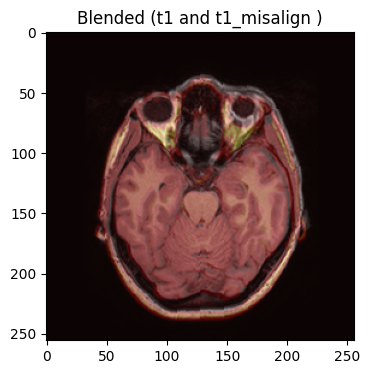

Patient number:  2


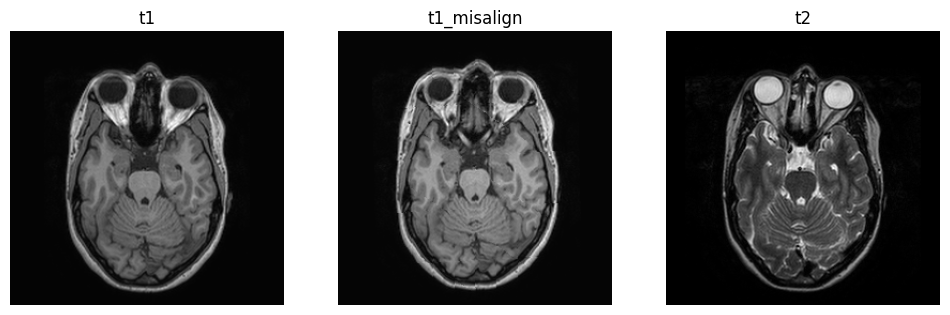

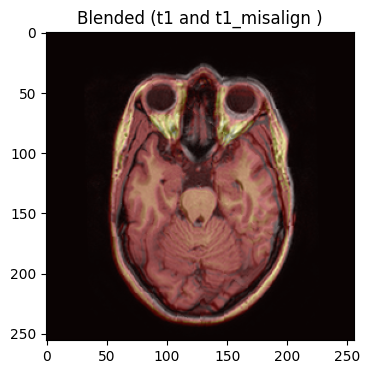

Patient number:  3


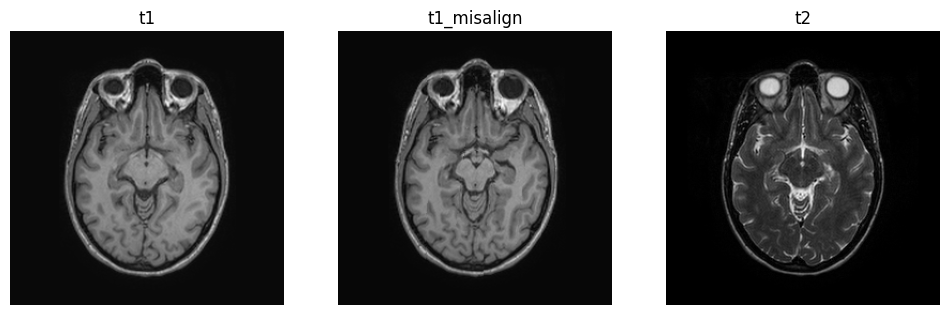

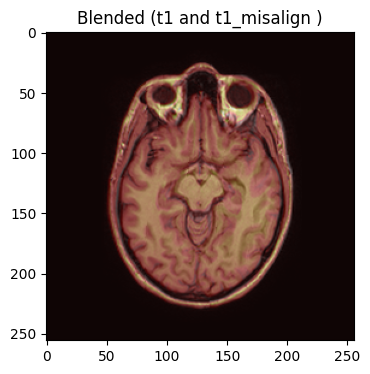

In [11]:
## Parameter confirmation after observing transform result

rand_3d_elastic_transform = Rand3DElastic(
    mode="nearest",
    prob=1.0,
    sigma_range=(3, 5), # Sigma range for smoothing random displacement
    magnitude_range=(0.1, 0.1, 0.1), # Deformation magnitude
    rotate_range=(0.1, 0.1, 0.1),
    shear_range=(0.025, 0.025, 0.025),
    translate_range=(3, 3, 3),
    padding_mode="border"
) 

root_dir = 'datasets/IXI/train'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

imtrans_transformed = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        rand_3d_elastic_transform # Apply misalign to t1 data
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        
    ]
)

ds = ArrayDataset(t1s, imtrans, t1s, imtrans_transformed, t2s, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())

# Observation of results in 3 patients
for idx, (im1, im1_trans, im2) in enumerate(loader):
    if idx >= 3:
        break
    print("Patient number: ", idx+1)
    def plot_2d_slice(images, image_names, slice_idx):
        fig, axes = plt.subplots(1, len(images), figsize=(12, 4))

        for idx, (image, title) in enumerate(zip(images, image_names)):
            slice_image = image[0, 0, :, :, slice_idx].cpu().numpy()
            axes[idx].imshow(slice_image, cmap='gray')
            axes[idx].axis('off')
            axes[idx].set_title(title)

        plt.show()

    # Plot the 25th slice
    slice_idx = 24
    plot_2d_slice([im1, im1_trans, im2], ['t1', 't1_misalign', 't2'], slice_idx)
    blended_align = blend_and_transpose(im1_trans[0,0,:,:,slice_idx], im1[0,0,:,:,slice_idx])
    plot_images([blended_align], ['Blended (t1 and t1_misalign )']) # Plot the images

In [12]:
transform_list.append(rand_3d_elastic_transform)
print(len(transform_list))

1


In [ ]:
## Generate numpy data for param in transform_params_list, calculate MI value
root_dir = 'datasets/IXI/train'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

for param_idx, transform in enumerate(transform_params_list):
    
    imtrans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )

    imtrans_transformed = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            transform # Apply misalign to t1 data
        ]
    )

    segtrans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            
        ]
    )

    ds = ArrayDataset(t1s, imtrans, t1s, imtrans_transformed, t2s, segtrans)

    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
    im1, im1_trans, im2 = first(loader)
    print(im1.shape, im1_trans.shape, im2.shape)

    # Save training dataset to numpy array file (Slice by Slice)
    t1_t1_mi = []
    t1_t2_mi = []
    for idx, (im1, im1_trans, im2) in tqdm(enumerate(loader), desc='3d image'):
        nslice = im1.shape[-1]

        for sl in range(nslice):
            t1_align_path = f'datasets/IXI/train/t1_align/t1_{idx}_{sl}.npy'
            t1_misalign_path = f'datasets/IXI/train/t1_misalign_{param_idx}/t1_{idx}_{sl}.npy'
            t2_path = f'datasets/IXI/train/t2/t2_{idx}_{sl}.npy'
            
            t1_align = im1[...,sl].squeeze() # shape: torch.Size([256, 256])
            t1_misalign = im1_trans[...,sl].squeeze()
            t2 = im2[...,sl].squeeze()

            os.makedirs(os.path.dirname(t1_align_path), exist_ok=True)
            os.makedirs(os.path.dirname(t1_misalign_path), exist_ok=True)
            os.makedirs(os.path.dirname(t2_path), exist_ok=True)

            if(param_idx == 0): # Operate only at the first time
                np.save(t1_align_path, t1_align)
                np.save(t2_path, t2)
            np.save(t1_misalign_path, t1_misalign)

            t1_t1_mi.append(calculate_mutual_info(t1_align, t1_misalign))
            t1_t2_mi.append(calculate_mutual_info(t2, t1_misalign)) 
        
    t1_t1_mi = np.array(t1_t1_mi)
    t1_t2_mi = np.array(t1_t2_mi)

    t1_t1_avg, t1_t1_var, t1_t1_std = np.mean(t1_t1_mi), np.var(t1_t1_mi), np.std(t1_t1_mi)
    t1_t2_avg, t1_t2_var, t1_t2_std = np.mean(t1_t2_mi), np.var(t1_t2_mi), np.std(t1_t2_mi)

    mi_path = f'datasets/IXI/train/t1_misalign_{param_idx}/MI_metric.txt'
    os.makedirs(os.path.dirname(mi_path), exist_ok=True)
    with open(mi_path, 'w') as f:
        f.write(f"T1-T1(Misaligned) Mutual Information:\n")
        f.write(f"Average: {t1_t1_avg}\nVariance: {t1_t1_var}\nStandard Deviation: {t1_t1_std}\n\n")
        
        f.write(f"T2-T1(Misaligned) Mutual Information:\n")
        f.write(f"Average: {t1_t2_avg}\nVariance: {t1_t2_var}\nStandard Deviation: {t1_t2_std}\n\n")

        f.write(f"T1-T1 Values: {', '.join(map(str, t1_t1_mi))}\n\n")
        f.write(f"T2-T1 Values: {', '.join(map(str, t1_t2_mi))}\n")

    params_path = f'datasets/IXI/train/t1_misalign_{param_idx}/params.txt'
    os.makedirs(os.path.dirname(params_path), exist_ok=True)
    with open(params_path, 'w') as f:
        for key, value in params.items():
            f.write(f"{key}: {value}\n")

    print("param",param_idx," Done")

## 3. Visualize the actual dataset (Patched 96x96)

In [ ]:
t1s_dir = 'datasets/IXI/train/t1_misalign_3' # Misaligned data
t2s_dir = 'datasets/IXI/train/t2'

t1s = sorted(glob.glob(os.path.join(t1s_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(t2s_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            ScaleIntensity(),
            RandSpatialCrop((64, 64), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            ScaleIntensity(),
            RandSpatialCrop((64, 64), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )


# define array dataset, data loader
check_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
check_loader = DataLoader(check_ds, batch_size=30, num_workers=2, pin_memory=torch.cuda.is_available())
t1, t2 = monai.utils.misc.first(check_loader)
print(t1.shape, t2.shape)

In [ ]:
fig = matshow3d(t1, show=True, cmap='gray',figsize=(5,5)) #TODO: matshow3d 기능 정리

In [ ]:
fig = matshow3d(t2, show=True, cmap='gray',figsize=(5,5))

In [ ]:
fig = plot_blended_images(t1,t2) # plot blended images (Use this function to plot the blended images of size: torch.Size([30, 1, 64, 64]) torch.Size([30, 1, 64, 64]))

## Process validation and test dataset

- Note: Validation and Test dataset has no misalignment

In [ ]:

root_dir = 'datasets/IXI/val'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

ds = ArrayDataset(t1s, imtrans, t2s, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
im1, im2 = first(loader)
print(im1.shape, im2.shape)

# Save training dataset to numpy array file (Slice by Slice)
for idx, (im1, im2) in tqdm(enumerate(loader), desc='3d image'):
    nslice = im1.shape[-1]
    for sl in range(nslice):
        np.save(f'datasets/IXI/val/t1_{idx}_{sl}.npy', im1[...,sl].squeeze())
        np.save(f'datasets/IXI/val/t2_{idx}_{sl}.npy', im2[...,sl].squeeze())
        

In [ ]:

root_dir = 'datasets/IXI/test'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

ds = ArrayDataset(t1s, imtrans, t2s, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
im1, im2 = first(loader)
print(im1.shape, im2.shape)

# Save training dataset to numpy array file (Slice by Slice)
for idx, (im1, im2) in tqdm(enumerate(loader), desc='3d image'):
    nslice = im1.shape[-1]
    for sl in range(nslice):
        np.save(f'datasets/IXI/test/t1_{idx}_{sl}.npy', im1[...,sl].squeeze())
        np.save(f'datasets/IXI/test/t2_{idx}_{sl}.npy', im2[...,sl].squeeze())
        

## TODO: make the whole code into a single code (that saves auxilary images)